# Conformational sampling of an alkane molecule

## Preliminaries

Import the Python packages we'll need, and initialise a simulation of a single alkane chain with 10 beads. We're not using periodic boundary conditions or a densely packed system, so disable use of link cells and Verlet lists for this example. By default we create only a single replica with index 1. Note that because the model code is written in Fortran internally, replicas, chains and bead indices are 1-based not zero-based. That can probably be changed....

In [1]:
import numpy as np  # Numpy
import math as m    # Maths

import hs_alkane.alkane as mdl # Fortran library we'll used to model the alkane chain

In [2]:
mdl.box_initialise()             # Initialise the simulation box
mdl.box_set_pbc(0)               # Don't use periodic boundary conditions
mdl.box_set_bypass_link_cells(1) # Bypass use of link cell algorithm for neighbour finding
mdl.box_set_use_verlet_list(0)   # Don't use Verlet lists either since CBMC moves quickly invalidate these

At this point we can access the matrix of cell vectors for our single box with mdl.box_get_cell(1) but since we're not using periodic boundary conditions there wouldn't be any point. 

## Create an initial configuration
To to this we initialise the alkane module inside the library (this isn't automatic - yet) after setting the number of chains and beads per chain that we want.

In [3]:
nchains = 1; nbeads = 10
mdl.alkane_set_nchains(nchains)   # 1 chain
mdl.alkane_set_nbeads(nbeads)     # 10 beads per chans
mdl.alkane_initialise()           # initialise alkane model with these settings

At this point we can access the coordinates of the chain used within the model via mdl.alkane_get_chain(), but these aren't populated yet so that will just return garbage. Instead let's instruct the library to grow a new chain from scratch via CBMC/Rosenbluth sampling. Note that we set new_conf=1 to indicate we want to grow a new chain from scratch rather than regrow a segment of an existing chain.

Note that sometimes the attempt to grow a new chain will fail because none of the ktrials attempts to place the next monomer were successful. This parameter can be increased with mdl.alkane_set_ktrial(). The default is 5.

In [4]:
rbfactor, ifail = mdl.alkane_grow_chain(1, 1, new_conf=1) # chain 1 in box 1
if ifail != 0 :
    print("Failed to grow a chain. Trying increasing number of trials per monomer (ktrials).")

A "Rosenbluth factor" is also returned. We will need when using this function to attempt CBMC moves. It is needed to determine the probability that the move will be accepted.

Assuming we managed to grow a chain, we might want to populate an ASE atoms object with them so that we can leverage ASE functionality in whatever on-the-fly analysis of the structure we might be interested in. We'll pretend our beads are carbon atoms for the purpose of visualisation, but we're not working in "real" units here so that choice doesn't really represent anything. Within this model one length unit is one bead diameter, and bead-beand bond length is 0.4 length units. So scaling up everything by a factor of (1.54/0.4) would give us something in Angstroms(ish).

In [5]:
from ase import Atoms

model_positions = mdl.alkane_get_chain(1, 1)
chain_config = Atoms('C10', positions=model_positions*(1.5/0.4), pbc=False)

We should now be able to visualise this.

In [6]:
from ase.visualize import view

v = view(chain_config, viewer='ngl')
v.view.clear_representations()
v.view.add_representation('ball+stick', radius=0.3)
v

## Dihedral angle moves
For an isolated chain it's not useful to explore rotatations or translations of the whole chain. Any property of a single chain that we might want to calculate is invariant to these. Since bond lengths and angles are constrained in our model, the only remaining degrees of freedom are dihedral angles. 

Lets make a backup of our current chain_config ASE object and try making a Monte Carlo move which changes a dihedral angle.

In [7]:
old_model_positions = model_positions.copy()   # Note copy, not a reference to the existing object 
old_chain_config    = chain_config.copy()      # Also backup the ASE object

Query the current maximum dihedral angle change in Monte Carlo moves of this kind, converting to degrees.

In [8]:
print("Maximum dihedral rotation ", mdl.alkane_get_dh_max()*180/m.pi, "degrees")

Maximum dihedral rotation  3.437746770784939 degrees


Make a trial move. This will update the model by picking a random dihedral alkane on a randomly selected chain and changing that angle by a random amount between +/- the above maximum. If we specify allow_flip=1 then there is a 50% possibility that an additional 120 degrees is added to this to switch us between 'gauche' and 'anti'-conformations about the central bond.

Wrinkle - as per above the beads on the chain are indexed by the model library as 1-based, whereas in Python we used zero-based indexing. We need to correct for that.

In [9]:
Pacc, atom1, angle = mdl.alkane_bond_rotate(1, 1, allow_flip=1)   # Chain 1 in box 1

print("Trial move changed dihedral involving beads :", [iatom-1 for iatom in range(atom1,atom1+4)])
print("Dihedral angle was changed by : ", angle*180/m.pi, "degrees")

Trial move changed dihedral involving beads : [2, 3, 4, 5]
Dihedral angle was changed by :  -1.4836617998212587 degrees


Visualise how that trial move has changed the conformation of the alkane chain. This should produce a two-frame animation with the old and new configuration.

In [10]:
chain_config = Atoms('C10', positions=model_positions*(1.5/0.4), pbc=False)
v = view([chain_config,old_chain_config], viewer='ngl')
v.view.clear_representations()
v.view.add_representation('ball+stick', radius=0.3)
v

When we made the move, a variable Pacc was returned. This tells use the probability that we should accept this move as our next sample of the chain conformation, rather than reject the move and count the previous sample again. For this hard-sphere model with a square-well dihedral potential Pacc will always be 1 or 0. In this case...

In [11]:
print("Move acceptance probability is ",Pacc)
if (Pacc>0):
    print("Move accepted")
else:
    print("Move rejected - restoring positions")
    for iatom in range(atom1+2,nbeads):                   # Note 
        print("Restoring bead ",iatom)
        model_positions[iatom] = old_model_positions[iatom] 

Move acceptance probability is  1.0
Move accepted


## Monte Carlo loop
We now just need to repeat this many times to build up samples. We'll sample the end-to-end distance of the chain after every move (for now), and store the configuration every 10 moves for visualisation purposes. First we need a function to calculate the end-to-end distance of the chain.

In [12]:
def end_to_end_distance(chain_positions):
    ee_vector = chain_positions[-1] - chain_positions[0]
    return np.linalg.norm(ee_vector)

Then sample this after every one of many trial moves.

In [13]:
from ipywidgets import IntProgress
from IPython.display import display

num_moves = 1000

f = IntProgress(min=0, max=num_moves) # instantiate the bar
display(f) # display the bar

samples = list()  # Samples of end-to-end distance
frames  = list()  # Frames for visualisation

for imove in range(num_moves):

    # Trial move
    old_model_positions = model_positions.copy() 
    Pacc, atom1, angle = mdl.alkane_bond_rotate(1, 1, allow_flip=1)

    # Accept or reject
    xi = np.random.random()
    if (xi>= Pacc):
        for iatom in range(atom1+2,nbeads):
            model_positions[iatom] = old_model_positions[iatom] 
    
    # Append the end-to-end distance to the list of samples
    samples.append(end_to_end_distance(model_positions))
    
    # Append a new frame every 10 samples
    if imove%10 == 0:
        frame = Atoms("C10", positions=model_positions*(1.5/0.4), pbc=False)
        frames.append(frame)
    
    f.value +=1  # Increment progress bar

IntProgress(value=0, max=1000)

Visualise the frames we sampled

In [14]:
v = view(frames, viewer='ngl')
v.view.clear_representations()
v.view.add_representation('ball+stick', radius=0.3)
v

Distribution of end-to-end distances

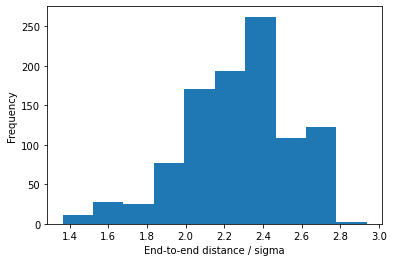

In [15]:
import matplotlib.pyplot as plt

plt.hist(samples)
plt.xlabel('End-to-end distance / sigma')
plt.ylabel('Frequency')
plt.show()

## Introducing configurational bias moves
We have access to a different Monte Carlo move which explores the conformation of the chain in a way which may be more efficient than tweaking individual dihedeal angles. This is the configurational bias move. It involves regrowing the chain from a randomly selected bead by generating random positions (subject to the model constraints) for each subsequent bead.

The move proceeds in two stages.

### Stage 1

1) Pick a random bead i on the chain.

2) Estimate the probability (via sampling over ktrial attempts at each bead) of growing the existing chain configuration. This is the "Rosenbluth factor" of the current chain.

### Stage 2

1) Delete all beads j>i on the chain.

2) Grow a new chain by making ktrial attempts to generate the position of each subsequent bead. We select one position from all those which don't generate hard sphere overlaps, and accumate an estimated probability of that particular position being generated based on our ktrial samples. We hence calculate the Rosenblush factor of the proposed new configuration of the chain.

An acceptance probability for the move can then be calculated which maintains detailed balance. We've retrospectively calculated the probability of attempting to grow the chain configuration we already have, and the probability of attempting to grow our new trial chain. Since the Boltzmann weight of the two configurations is the same in our athermal model, the probability of accepting the move is just the ratio of the two Rosenbluth factors.

Let's look at an example.

In [16]:
# Set ktrial
mdl.alkane_set_ktrial(5)

# Backup the current chain configuration 
old_model_positions = model_positions.copy()   # Note copy, not a reference to the existing object 
old_chain_config    = chain_config.copy()      # Also backup the ASE object

# First stage - calculate RBfactor for the current configuration
old_rbfactor, ifail = mdl.alkane_grow_chain(1, 1, new_conf=0)

print("Rosenbluth factor of original configuration : ",old_rbfactor)

Rosenbluth factor of original configuration :  25.0


Note that we don't get any information about which bead the chain was regrown from. We don't need to care.

In [17]:
# Second stage - calculate RBfactor for a new trial configuration
new_rbfactor, ifail = mdl.alkane_grow_chain(1, 1, new_conf=1)

if (ifail==0):
    print("Rosenbluth factor of new trial configuration : ", new_rbfactor)
else:
    print("Failed to generate enough non-overlapping configurations at each segment.")
    print("Try increasing ktrial from its current value of ",mdl.alkane_get_ktrial())

Rosenbluth factor of new trial configuration :  10.0


Visualise the old and new configurations.

In [18]:
chain_config = Atoms('C10', positions=model_positions*(1.5/0.4), pbc=False)
v = view([chain_config,old_chain_config], viewer='ngl')
v.view.clear_representations()
v.view.add_representation('ball+stick', radius=0.3)
v

It should be clear that this changes more than one dihedral angle, and so fewer moves of this kind should be required for equivalent quality sampling. However these moves require more operations than single dihedral changes, and so will take longer to execute. Finding an optimal balance between the two moves types is desirable for efficiency.

In [19]:
print("Move acceptance probability is ",new_rbfactor/old_rbfactor)
if (np.random.random() < Pacc):
    print("Move accepted")
else:
    print("Move rejected - restoring positions")
    # Restore hold chain from backup
    model_positions = old_model_positions 

Move acceptance probability is  0.4
Move accepted
